# Transfer Labels Using an Sklearn Classifier

This is a tutorial about how to do automated label transfer for two tissues at once, using an `sklearn` classifier and the `anndict` package to simplify the syntax. We'll be using example data from Cellxgene census. Our goal is simple: transfer the cell type label from `origin_adata` to `destination_adata`.

## Skip the tutorial
In case you want to skip the tutorial, here's all the code you need to run this type of label transfer.

## On a single adata

``` python
#import adict package
import anndict as adt
from sklearn.linear_model import LogisticRegression

#load already labeled data
origin_adata = adt.read_adata_dict_from_h5ad("path_to_your_data.h5ad")

#load unlabeled data
destination_adata = adt.read_adata_dict_from_h5ad("path_to_your_data.h5ad")

#transfer the labels
adt.transfer_labels_using_classifier(
    origin_adata=origin_adata,
    destination_adata=destination_adata,
    origin_label_key="cell_type", 
    feature_key="X_pca", #the key in origin_adata.obsm that contains the features you want to use for label transfer
    classifier=LogisticRegression(),
    new_column_name="predicted_cell_type",
    random_state=42 #for reproducibility
    )

#save the labeled data
adt.write_adata_dict(adata_dict=destination_adata, filename="path/to/your/labeled/adata_dict")

## On many adata at once

``` python
#import adict package
import anndict as adt
from sklearn.linear_model import LogisticRegression

#load already labeled data
origin_adata_dict = adt.read_adata_dict_from_h5ad("/path/to/your/labeled/adata")

#load unlabeled data
destination_adata_dict = adt.read_adata_dict_from_h5ad("/path/to/your/unlabeled/adata")

#transfer the labels
adt.adata_dict_fapply(
    origin_adata_dict,
    adt.transfer_labels_using_classifier,
    destination_adata=destination_adata_dict,
    origin_label_key="cell_type", 
    feature_key="X_pca", #the key in origin_adata.obsm that contains the features you want to use for label transfer
    classifier=LogisticRegression(),
    new_column_name="predicted_cell_type",
    random_state=42 #for reproducibility
    )

#save the labeled data
adt.write_adata_dict(adata_dict=destination_adata_dict, filename="path/to/your/labeled/adata_dict")

## Begin the tutorial
The rest of this notebook is a detailed tutorial about how to transfer labels using `adata_dicts` to handle several samples at once.

For example, transfer labels between several tissues at once (i.e. with the same code):  
Origin ----> Destination  
Labeled Liver ---> Unlabeled Liver  
Labeled Kidney ----> Unlabeled Kidney

The steps that we'll follow are:
1. Download test data from cellxgene census.
2. Split the data by `tissue` so that we can use a separate classifier for each tissue.
3. Randomly split the data into `origin` and `destination` data. This mean's we'll also have "ground truth" labels in the destination data that we can compare to (i.e. just the original labels).
4. Downsample large cell types in the training data (to decrease the computational burden of training classifiers).
5. Drop small cell types.
6. Train a label classifier on each tissue.
7. Use this classifier to predict (aka transfer) labels for the destination dataset.
8. Visualize the results and compare to the manual labels.

### 1. Download test data from cellxgene census.

In [1]:
#1. Download the data
import cellxgene_census

census = cellxgene_census.open_soma(census_version="2023-12-15")
adata = cellxgene_census.get_anndata(
    census,
    organism = "homo_sapiens",
    measurement_name = "RNA",
    obs_value_filter = "(dataset_id == '53d208b0-2cfd-4366-9866-c3c6114081bc') & ((tissue_general == 'kidney') | (tissue_general == 'liver'))",
    obs_embeddings = ["uce"] #we can try training the label transfer model on different embeddings
)

In [2]:
#import AnnDictionary
import anndict as adt

In [3]:
# Here's what the data looks like
adt.display_html_summary(adt.summarize_metadata(adata,  cols=['tissue','cell_type', 'cell_type*tissue']))

,count
kidney,9641
liver,5007
,count
kidney epithelial cell,8331
macrophage,1702
hepatocyte,1558
monocyte,612
endothelial cell of hepatic sinusoid,421
mature NK T cell,376
endothelial cell,362


### 2. Split the data by `tissue` so that we can use a separate classifier for each tissue.

In [4]:
#split the adata by tissue so that we can handle each separatley
adt.convert_obs_col_to_category(adata, 'tissue') #needs to be a category to build_adata_dict
adt.convert_obs_col_to_category(adata, 'cell_type') #for operations later
adata_dict = adt.build_adata_dict(adata, strata_keys=['tissue'])

### 3. Randomly split the data into `origin` and `destination` data.
This mean's we'll also have "ground truth" labels in the destination data that we can compare to (i.e. just the original labels).

The `anndictionary` way of doing this is to write a function that takes `adata` and does what you want, then use `adata_dict_fapply()` to do ``function`` to each adata in ``adata_dict``

In [ ]:
def assign_training_test_split(
    adata,
    random_state: int | None = 42):
    """
    Assigns 50/50 train/test split to adata by adding 'is_training' column
    
    Parameters
    -----------
    adata
        AnnData object

    random_state
        Random seed for reproducibility

    Returns
    -------
    None
    """
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    train_mask = np.full(len(adata), "destination", dtype=object)
    train_idx, _ = train_test_split(
        range(len(adata)), test_size=0.5, random_state=random_state
    )
    train_mask[train_idx] = "origin"
    adata.obs['is_origin'] = pd.Categorical(train_mask)

#randomly split adata into 50/50 origin (train) and destination (test)
adt.adata_dict_fapply(adata_dict, assign_training_test_split)
adata_dict.add_stratification(strata_keys=['is_origin'])

In [6]:
adata_dict.__class__

anndict.adata_dict.adata_dict.AdataDict

In [7]:
adata_dict #View the object

{('destination',): {('liver',): AnnData object with n_obs × n_vars = 2504 × 60664
      obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'is_origin'
      var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
      obsm: 'uce',
  ('kidney',): AnnData object with n_obs × n_vars = 4821 × 60664
      obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'dise

### 4. Downsample large cell types in the training data (to decrease the computational burden of training classifiers).
and
### 5. Drop small cell types.

In [8]:
#subsample each origin/training data down to 1k cells per cell type, dropping cell types with fewer than 50 cells
adata_dict[('origin',)] = adt.wrappers.sample_and_drop_adata_dict(adata_dict[('origin',)], strata_keys=['cell_type'], min_num_cells=50, n_obs=300)

In [9]:
#Check the results, note that the "origin" data has been subsampled and had cell types with fewer than 50 cells removed
#The type of classifier that we'll use next doesn't handle highly imbalanced classes (i.e. a mix of small and large cell types (by count))
summary_results = adt.wrappers.summarize_metadata_adata_dict(adata_dict[('origin',)], cols=["cell_type*tissue"])
adt.wrappers.display_html_summary_adata_dict(summary_results)

Summary for: ('liver',)


,liver
T cell,69
endothelial cell,126
endothelial cell of hepatic sinusoid,201
erythrocyte,68
hepatocyte,300
macrophage,300
mature NK T cell,129
monocyte,300


Summary for: ('kidney',)


,kidney
B cell,171
CD4-positive helper T cell,95
"CD8-positive, alpha-beta T cell",135
kidney epithelial cell,300
macrophage,162
mature NK T cell,64


In [10]:
#Note the nesting structure of the adata_dict
adata_dict.hierarchy #first level is origin/destination, second level is tissue

('is_origin', ('tissue',))

### 6. Train a label classifier on each tissue.  
and  
### 7. Use this classifier to predict (aka transfer) labels for the destination dataset.

In this case, we have the UCE embedding already downloaded from cellxgene. So, we'll use that for training and prediction.

However, you could use on anything. For example:
- Put some metadata columns from .obs into a .obsm key and use those features
- Put some genes into a .obsm key and use those genes
- Calculate a PCA embedding and use that
- Directly on the raw counts, or normalized, or whatever you have in ``.X``, just pass ``feature_key='use_X'``

Note that the same .obsm key needs to be present in both the origin and destination data.

In [11]:
#Now, transfer the labels from origin to destination
#If SLURM_CPUS_PER_TASK and/or SLURM_NTASKS environment variables are set, the function will automatically determine number of cores and multithread using adt.get_slurm_cores()
from sklearn.linear_model import LogisticRegression

label_transfer_models = adt.adata_dict_fapply(
                                    adata_dict[('origin',)],
                                    adt.transfer_labels_using_classifier,
                                    destination_adata=adata_dict[('destination',)],
                                    origin_label_key='cell_type', 
                                    feature_key='uce', #the key in origin_adata.obsm that contains the features you want to use for label transfer
                                    classifier_class=LogisticRegression,
                                    new_column_name='predicted_cell_type',
                                    random_state=42 #for reproducibility
                                    )

### 8. Visualize the results and compare to the manual labels.

There are a few plotting functions for label comparison in ``anndictionary``. For the complete list, look at the following section of the online documentation: API > Plot.

Here, we'll do a few:
- UMAP Plots labeled by the ground truth and predicted cell types.
- Confusion Matrices.
- Sankey Plots.

In [ ]:
adt.wrappers.neighbors_adata_dict(adata_dict[('destination',)], use_rep='uce')

In [13]:
adt.wrappers.calculate_umap_adata_dict(adata_dict[('destination',)])

Plotting UMAP for key: ('liver',)


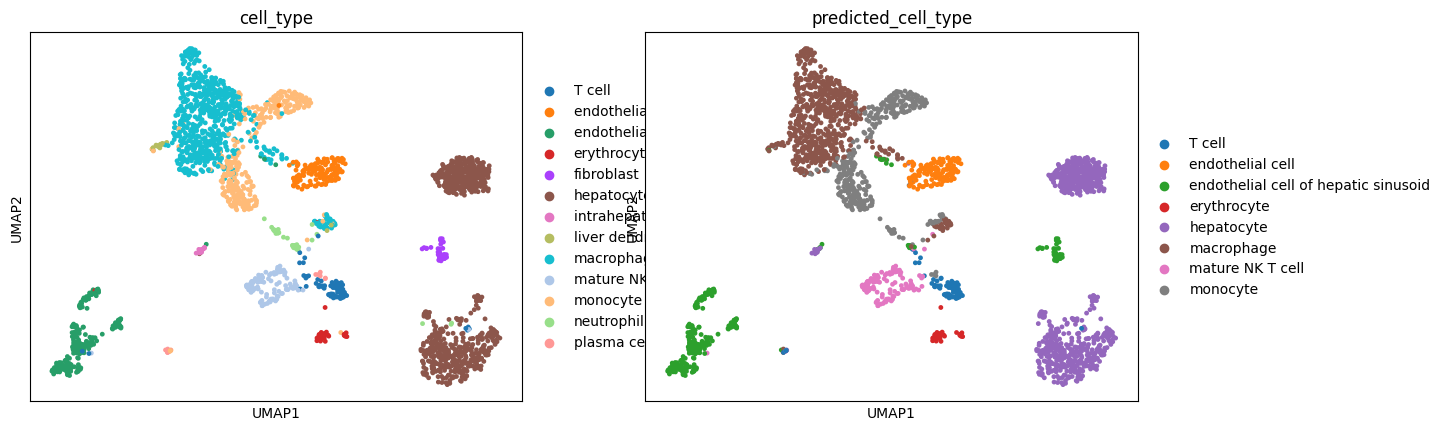

Plotting UMAP for key: ('kidney',)


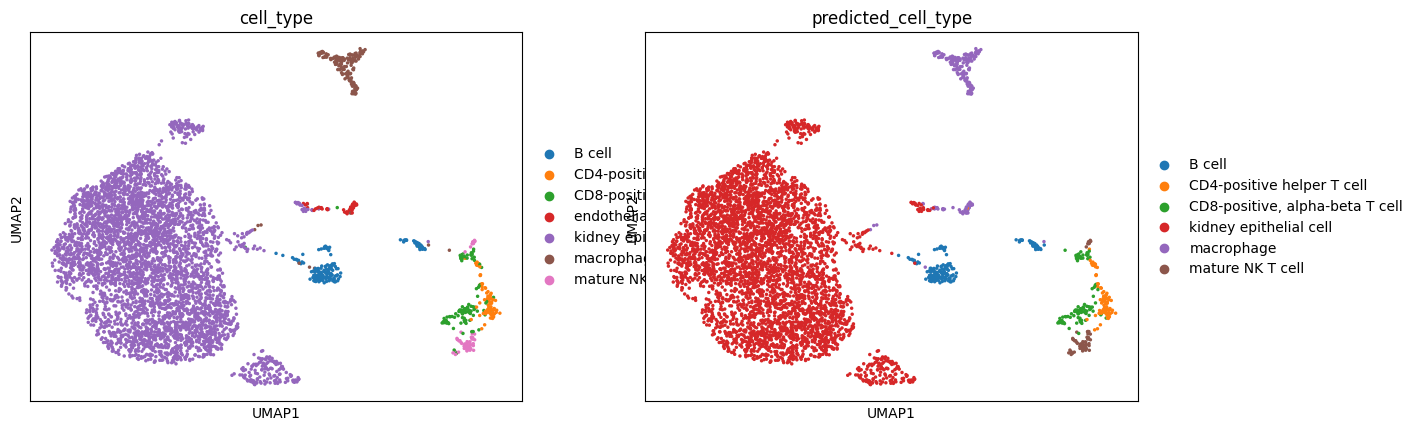

In [14]:
# plot UMAP
adt.wrappers.plot_umap_adata_dict(adata_dict[('destination',)], color=['cell_type', 'predicted_cell_type'])

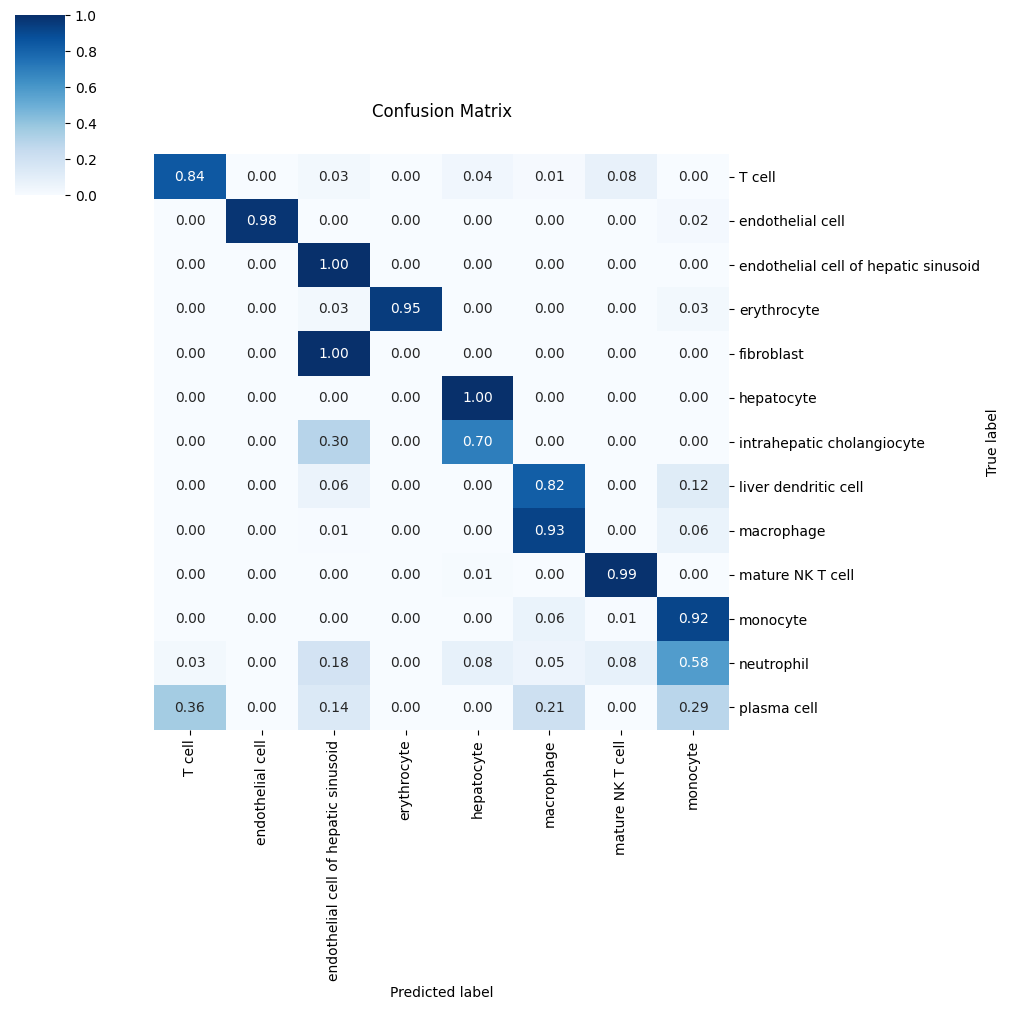

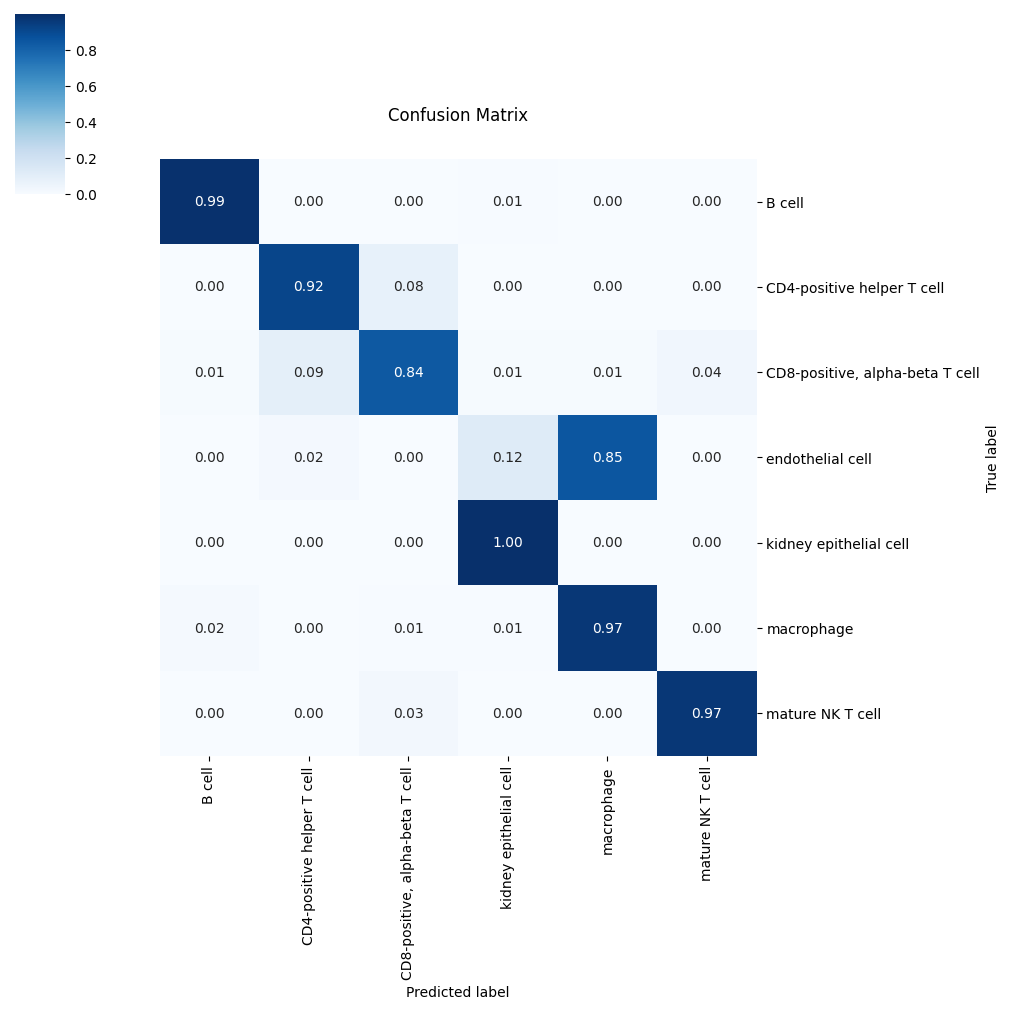

In [15]:
adt.wrappers.plot_confusion_matrix_adata_dict(adata_dict[("destination",)], 'cell_type', 'predicted_cell_type',
                                     row_color_keys=None, col_color_keys=None)